In [2]:
# import the necessary libraries you need for your analysis
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd 
%matplotlib inline

# warnings supression
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
# read in csv file and display first 5 rows of datset
df = pd.read_excel("data/MuesliProject_raw_data.xlsx")

In [4]:
# read in csv file and display first 5 rows of datset
df_campaign = pd.read_excel("data/MuesliProject_raw_data.xlsx",sheet_name='Campaign Data')
df_process = pd.read_excel("data/MuesliProject_raw_data.xlsx",sheet_name='Order Process Data')
df_intern = pd.read_excel("data/MuesliProject_raw_data.xlsx",sheet_name='InternData Study')

In [5]:
#column cleaning
headers = df.iloc[0]
df.rename(columns=headers, inplace=True)
df.drop(df.index[0], inplace=True)

#drop the new index column
df = df.reset_index(col_level=0)
df.drop('index',axis=1,inplace=True)

In [6]:
#change the column description - underscore instead of space and all str lower
cols = df.columns.tolist()
df.columns = [col.replace(' ','_').lower()for col in cols]

cols = df_campaign.columns.tolist()
df_campaign.columns = [col.replace(' ','_').lower()for col in cols]

cols = df_process.columns.tolist()
df_process.columns = [col.replace(' ','_').lower()for col in cols]

cols = df_intern.columns.tolist()
df_intern.columns = [col.replace(' ','_').lower()for col in cols]


In [7]:
#drop the duplicates from these tables
df_campaign.drop_duplicates(subset='order_id', keep='first' ,inplace=True, ignore_index=False)
df_process.drop_duplicates(subset='order_id', keep='first' ,inplace=True, ignore_index=False)
df_intern.drop_duplicates(subset='order_id', keep='first' ,inplace=True, ignore_index=False)
df.drop_duplicates(subset='order_id', keep='first' ,inplace=True, ignore_index=False)

In [8]:
#merge all tables
df_arrival= df.merge(df_campaign, how='left' , on='order_id').merge(df_process,how='inner', on='order_id').merge(df_intern,how='left', on='order_id')

In [9]:
#only take the column that are needed
df_arrival_final = df_arrival[["order_id", "order_date_x", "ready_to_ship_date", "pickup_date", "on_truck_scan_date", "arrival_scan_date", "ship_mode_y", "ship_mode_x"]]

In [10]:
#the final order process table
df_order_process_final = df_arrival_final[["order_id", "order_date_x", "on_truck_scan_date" ,"ship_mode_y", "ship_mode_x"]]
df_order_process_final.head()

,order_id,order_date_x,on_truck_scan_date,ship_mode_y,ship_mode_x
0,CA-2019-121755,2019-01-16 00:00:00,2019-01-23,Standard Processing,Second Class
1,CA-2019-118255,2019-03-11 00:00:00,2019-03-13,Express,First Class
2,CA-2019-169194,2019-06-20 00:00:00,2019-06-26,Standard Processing,Standard Class
3,CA-2019-111682,2019-06-17 00:00:00,2019-06-19,Express,First Class
4,CA-2020-155558,2020-10-26 00:00:00,2020-11-04,Standard Processing,Standard Class


In [11]:
#the final campaign table
df_campaign_final = df_order_process_final.merge(df_campaign, how='inner' , on='order_id')
df_campaign_final.head()

,order_id,order_date_x,on_truck_scan_date,ship_mode_y,ship_mode_x,arrival_scan_date,customer_name
0,CA-2019-145625,2019-09-11 00:00:00,2019-09-18,Standard Processing,Standard Class,2019-09-23,Kelly Collister
1,CA-2019-162138,2019-04-23 00:00:00,2019-05-01,Standard Processing,Standard Class,2019-05-06,Grace Kelly
2,CA-2019-169166,2019-05-09 00:00:00,2019-05-15,Standard Processing,Standard Class,2019-05-20,Sonia Sunley
3,CA-2020-131954,2020-01-21 00:00:00,2020-01-29,Standard Processing,Standard Class,2020-02-03,Darrin Sayre
4,CA-2019-102981,2019-09-06 00:00:00,2019-09-11,Standard Processing,Second Class,2019-09-16,Mary O'Rourke


In [12]:
#the final intern table
df_intern_final = df_order_process_final.merge(df_intern, how='inner' , on='order_id')
df_intern_final.head() 

,order_id,order_date_x,on_truck_scan_date,ship_mode_y,ship_mode_x,ready_to_ship_date,pickup_date
0,CA-2020-119004,2020-11-23 00:00:00,2020-12-02,Standard Processing,Standard Class,2020-11-30,2020-12-02
1,CA-2019-145625,2019-09-11 00:00:00,2019-09-18,Standard Processing,Standard Class,2019-09-17,2019-09-18
2,CA-2020-135307,2020-11-26 00:00:00,2020-11-27,Express,First Class,2020-11-27,2020-11-27
3,CA-2019-102981,2019-09-06 00:00:00,2019-09-11,Standard Processing,Second Class,2019-09-09,2019-09-11
4,US-2020-155425,2020-11-10 00:00:00,2020-11-12,Express,First Class,2020-11-11,2020-11-12


In [13]:
#to cut out the weekend and only have weekdays
df_intern_final["work_days_to_process"]=np.busday_count(df_intern_final ['order_date_x'].values.astype('datetime64[D]'), df_intern_final ['ready_to_ship_date'].values.astype('datetime64[D]'), weekmask='Mon Tue Wed Thu Fri')

In [14]:
#to cut out the weekend and only have weekdays
df_intern_final["work_days_to_truck"]=np.busday_count(df_intern_final ['order_date_x'].values.astype('datetime64[D]'), df_intern_final ['on_truck_scan_date'].values.astype('datetime64[D]'), weekmask='Mon Tue Wed Thu Fri')

In [15]:
df_intern_final['waiting_for_truck'] = df_intern_final['work_days_to_truck'] - df_intern_final['work_days_to_process']

In [16]:
df_intern_final = df_intern_final[["order_id","order_date_x","on_truck_scan_date","ship_mode_y","ship_mode_x","ready_to_ship_date","pickup_date","work_days_to_process","waiting_for_truck","work_days_to_truck"]]

In [17]:
#to cut out the weekend and only have weekdays
df_campaign_final["total_delivery_days"]=np.busday_count(df_campaign_final ['order_date_x'].values.astype('datetime64[D]'), df_campaign_final ['arrival_scan_date'].values.astype('datetime64[D]'), weekmask='Mon Tue Wed Thu Fri')

In [18]:
df_campaign_final['total_delivery_days_w_weekend'] = (df_campaign_final['arrival_scan_date'] - df_campaign_final['order_date_x']).dt.days 

/opt/homebrew/Caskroom/miniconda/base/envs/musli/lib/python3.10/site-packages/pandas/core/arrays/datetimelike.py:1187: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized
  warnings.warn(


In [19]:
df_campaign_final["week_day_arrival"] =df_campaign_final["arrival_scan_date"].dt.day_name()

In [20]:
df_campaign_final['order_date_x'] = pd.to_datetime(df_campaign_final['order_date_x'])
df_campaign_final["week_day_arrival"] =df_campaign_final["arrival_scan_date"].dt.day_name()
df_campaign_final["week_day_order"] =df_campaign_final["order_date_x"].dt.day_name()


In [21]:
df_campaign_final['how_many_weekends'] = ((df_campaign_final['total_delivery_days_w_weekend'] - df_campaign_final['total_delivery_days'])/2)
df_campaign_final['how_many_weekends'] = df_campaign_final['how_many_weekends'].astype('int64')

In [22]:
df_campaign_final.head(3)

,order_id,order_date_x,on_truck_scan_date,ship_mode_y,ship_mode_x,arrival_scan_date,customer_name,total_delivery_days,total_delivery_days_w_weekend,week_day_arrival,week_day_order,how_many_weekends
0,CA-2019-145625,2019-09-11,2019-09-18,Standard Processing,Standard Class,2019-09-23,Kelly Collister,8,12,Monday,Wednesday,2
1,CA-2019-162138,2019-04-23,2019-05-01,Standard Processing,Standard Class,2019-05-06,Grace Kelly,9,13,Monday,Tuesday,2
2,CA-2019-169166,2019-05-09,2019-05-15,Standard Processing,Standard Class,2019-05-20,Sonia Sunley,7,11,Monday,Thursday,2


In [23]:
pd.crosstab(index=df_intern_final["ship_mode_y"],columns=df_intern_final["work_days_to_process"], normalize="index")\
    .round(4)*100

work_days_to_process,0,1,2,3,4,5
ship_mode_y,,,,,,
Express,33.96,15.09,28.30,22.64,0.00,0.00
Standard Processing,2.65,2.65,19.87,29.80,31.79,13.25


## Getting to know Müsli

what kind of business are we dealing with?

Sales and Profit

The warehouse manager described the workflow as follows: Order received (Day 1)
order processed in warehouse and made ready to ship (normally 2 days) 
order leaves warehouse in truck following day - order delivered to customer (handled by logistics company).

### thesis of warehouse manager: "order processes in warehouse normally take 2 days"

### Is this true?

In [24]:
df_intern_final['work_days_to_process'].describe()

count    204.000000
mean       2.769608
std        1.417991
min        0.000000
25%        2.000000
50%        3.000000
75%        4.000000
max        5.000000
Name: work_days_to_process, dtype: float64

In [45]:
total_by_DayOfWeek = df_intern_final.groupby("work_days_to_process", as_index=False)["order_id"].count()\
    .rename(columns={"order_id":"total"})

total_by_DayOfWeek

,work_days_to_process,total
0,0,22
1,1,12
2,2,45
3,3,57
4,4,48
5,5,20


0   10,8%
1   5,9%
2   22,1%
3   27,9%
4   23,5%
5   9,8%

## Only 38% of orders are being processed in 2 days or less.
### Mostly it takes 3 days to process an order.

<br>

### Let's take a deeper look at EXPRESS and STANDARD processing.

In [25]:
df_intern_final.groupby('ship_mode_y')['work_days_to_process'].describe()

,count,mean,std,min,25%,50%,75%,max
ship_mode_y,,,,,,,,
Express,53.0,1.396226,1.182234,0.0,0.0,2.0,2.0,3.0
Standard Processing,151.0,3.251656,1.155962,0.0,2.5,3.0,4.0,5.0


### EXPRESS processing takes 1,39 days on average to get the label "ready to ship".


### For round about 75% of all orders the processing time takes 3,25 days on average.

### Here by the thesis of the warehouse manager is NOT true.

Orders leave on trucks the day after they are made ready for shipping (or two days later if there is no truck)

Customers can pay for Express Processing that means the orders leave on the truck the day the order is ready for shipping.

Assumption: If the order is "ready to ship" it will only take two days to being picked up.

In [57]:
display(df_intern_final['waiting_for_truck'].max())
df_intern_final["week_day_order"] =df_intern_final["ready_to_ship_date"].dt.day_name()
df_intern_final.query('waiting_for_truck >= 3').head()

3

,order_id,order_date_x,on_truck_scan_date,ship_mode_y,ship_mode_x,ready_to_ship_date,pickup_date,work_days_to_process,waiting_for_truck,work_days_to_truck,week_day_order
6,CA-2020-122504,2020-11-07,2020-11-12,Standard Processing,Second Class,2020-11-09,2020-11-12,0,3,3,Monday
13,CA-2020-152737,2020-11-07,2020-11-12,Standard Processing,Standard Class,2020-11-09,2020-11-12,0,3,3,Monday
28,CA-2020-102610,2020-11-04,2020-11-12,Standard Processing,Standard Class,2020-11-09,2020-11-12,3,3,6,Monday
30,US-2020-122672,2020-11-04,2020-11-12,Standard Processing,Standard Class,2020-11-09,2020-11-12,3,3,6,Monday
49,CA-2020-167941,2020-11-06,2020-11-12,Standard Processing,Second Class,2020-11-09,2020-11-12,1,3,4,Monday


,order_id,order_date_x,on_truck_scan_date,ship_mode_y,ship_mode_x,ready_to_ship_date,pickup_date,work_days_to_process,waiting_for_truck,work_days_to_truck,week_day_order
6,CA-2020-122504,2020-11-07,2020-11-12,Standard Processing,Second Class,2020-11-09,2020-11-12,0,3,3,Monday
13,CA-2020-152737,2020-11-07,2020-11-12,Standard Processing,Standard Class,2020-11-09,2020-11-12,0,3,3,Monday
28,CA-2020-102610,2020-11-04,2020-11-12,Standard Processing,Standard Class,2020-11-09,2020-11-12,3,3,6,Monday
30,US-2020-122672,2020-11-04,2020-11-12,Standard Processing,Standard Class,2020-11-09,2020-11-12,3,3,6,Monday
49,CA-2020-167941,2020-11-06,2020-11-12,Standard Processing,Second Class,2020-11-09,2020-11-12,1,3,4,Monday
58,CA-2020-121615,2020-11-03,2020-11-12,Standard Processing,Standard Class,2020-11-09,2020-11-12,4,3,7,Monday
66,CA-2020-142636,2020-11-03,2020-11-12,Standard Processing,Standard Class,2020-11-09,2020-11-12,4,3,7,Monday
90,CA-2020-157196,2020-11-05,2020-11-12,Standard Processing,Standard Class,2020-11-09,2020-11-12,2,3,5,Monday
95,CA-2020-100622,2020-11-03,2020-11-12,Standard Processing,Standard Class,2020-11-09,2020-11-12,4,3,7,Monday
111,CA-2020-161130,2020-11-03,2020-11-12,Standard Processing,Standard Class,2020-11-09,2020-11-12,4,3,7,Monday


In [48]:
df_intern_final

,order_id,order_date_x,on_truck_scan_date,ship_mode_y,ship_mode_x,ready_to_ship_date,pickup_date,work_days_to_process,waiting_for_truck,work_days_to_truck
0,CA-2020-119004,2020-11-23 00:00:00,2020-12-02,Standard Processing,Standard Class,2020-11-30,2020-12-02,5,2,7
1,CA-2019-145625,2019-09-11 00:00:00,2019-09-18,Standard Processing,Standard Class,2019-09-17,2019-09-18,4,1,5
2,CA-2020-135307,2020-11-26 00:00:00,2020-11-27,Express,First Class,2020-11-27,2020-11-27,1,0,1
3,CA-2019-102981,2019-09-06 00:00:00,2019-09-11,Standard Processing,Second Class,2019-09-09,2019-09-11,1,2,3
4,US-2020-155425,2020-11-10 00:00:00,2020-11-12,Express,First Class,2020-11-11,2020-11-12,1,1,2
...,...,...,...,...,...,...,...,...,...,...
199,CA-2020-152142,2020-11-14 00:00:00,2020-11-18,Standard Processing,Standard Class,2020-11-16,2020-11-18,0,2,2
200,US-2019-134488,2019-09-24 00:00:00,2019-10-02,Standard Processing,Standard Class,2019-10-01,2019-10-02,5,1,6
201,CA-2020-103499,2020-11-20 00:00:00,2020-11-25,Standard Processing,Standard Class,2020-11-24,2020-11-25,2,1,3
202,US-2020-165456,2020-11-30 00:00:00,2020-12-04,Express,First Class,2020-12-03,2020-12-04,3,1,4


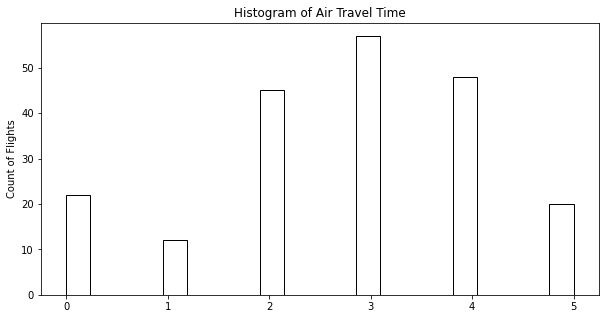

In [26]:
fig, ax = plt.subplots(figsize=(10,5))
bins = 21 # a nice number of bins based on range
(
    df_intern_final.hist(ax=ax,column='work_days_to_process',
          bins=bins, 
          edgecolor="black", 
          linewidth=1, color='w')
)
# These can also be set in the hist method
ax.grid(False)
ax.set_title('Histogram of Air Travel Time')
ax.set_ylabel('Count of Flights');

In [27]:
df_intern_final

,order_id,order_date_x,on_truck_scan_date,ship_mode_y,ship_mode_x,ready_to_ship_date,pickup_date,work_days_to_process,waiting_for_truck,work_days_to_truck
0,CA-2020-119004,2020-11-23 00:00:00,2020-12-02,Standard Processing,Standard Class,2020-11-30,2020-12-02,5,2,7
1,CA-2019-145625,2019-09-11 00:00:00,2019-09-18,Standard Processing,Standard Class,2019-09-17,2019-09-18,4,1,5
2,CA-2020-135307,2020-11-26 00:00:00,2020-11-27,Express,First Class,2020-11-27,2020-11-27,1,0,1
3,CA-2019-102981,2019-09-06 00:00:00,2019-09-11,Standard Processing,Second Class,2019-09-09,2019-09-11,1,2,3
4,US-2020-155425,2020-11-10 00:00:00,2020-11-12,Express,First Class,2020-11-11,2020-11-12,1,1,2
...,...,...,...,...,...,...,...,...,...,...
199,CA-2020-152142,2020-11-14 00:00:00,2020-11-18,Standard Processing,Standard Class,2020-11-16,2020-11-18,0,2,2
200,US-2019-134488,2019-09-24 00:00:00,2019-10-02,Standard Processing,Standard Class,2019-10-01,2019-10-02,5,1,6
201,CA-2020-103499,2020-11-20 00:00:00,2020-11-25,Standard Processing,Standard Class,2020-11-24,2020-11-25,2,1,3
202,US-2020-165456,2020-11-30 00:00:00,2020-12-04,Express,First Class,2020-12-03,2020-12-04,3,1,4
